# Análise de Currículos Lattes — Relatório

## Título e Integrantes

Projeto: Análise de Currículos Lattes (CNPq)

Equipe:

- Sarah Fernanda Calixto de Araújo — `20240011267`
- Luiz Carlos Veloso de Araujo Lima Neto — `20240102334`
- Sofia Pontes Leitão de Lima — `20240011285`
- Cauã Henrique Formiga de Lacerda — `20240011089`


## Introdução

Este relatório apresenta a análise exploratória e modelagem de dados extraídos da Plataforma Lattes, com foco em compreender padrões de produção acadêmica, redes de colaboração e temas de pesquisa de docentes/pesquisadores. O trabalho está estruturado para documentar objetivos, dados, pré-processamento, perguntas analíticas e conclusões.

Objetivos específicos:

- Mapear o perfil dos pesquisadores a partir de seus currículos (resumo, formação, produções, colaborações).
- Explorar a distribuição e evolução temporal da produção acadêmica.
- Identificar estruturas de colaboração (coautorias, projetos) e possíveis comunidades.
- Investigar fatores associados à produtividade científica.
- Descobrir agrupamentos temáticos de pesquisadores via técnicas de clustering.

Contexto técnico do projeto:

- Coleta com Playwright (navegação e captura dos HTMLs dos currículos).
- Extração com BeautifulSoup e consolidação com Pandas.
- Scripts principais em `scripts/` e artefatos em `data/` e `professores_perfil_html/`.


## Dados usados (descrição e exploração inicial)

Arquivos e fontes do projeto:

| Arquivo/Path                       | Papel                                       | Observações                                    |
| ---------------------------------- | ------------------------------------------- | ---------------------------------------------- |
| `data/professores_ci.csv`          | Lista de entrada com docentes/pesquisadores | Ponto de partida para scraping.                |
| `professores_perfil_html/`         | HTMLs dos currículos Lattes                 | Saída do script de download com Playwright.    |
| `data/professores.csv`             | Dados consolidados (CSV)                    | Saída do parser (`scripts/parse_profiles.py`). |
| `data/professores.json`            | Dados consolidados (JSON)                   | Alternativa de saída do parser.                |
| `data/prof_labs.csv`               | Mapeamento professor ↔ laboratório          | Usado para análises por laboratório/grupo.     |
| `data/publicacoes_unificadas.json` | Produções agregadas (quando disponível)     | Facilita análises temporais e por tipo.        |

Perguntas de exploração inicial (EDA):

- Quantos perfis foram coletados e processados? Há registros ausentes (NAs) em campos-chave?
- Como é a distribuição de produção por pesquisador, por ano e por tipo (artigo, conferência, capítulo, etc.)?
- Quais palavras-chave/termos são mais frequentes em resumos e títulos de publicações?
- Como se distribuem os pesquisadores por laboratório/grupo (quando houver `prof_labs.csv`)?

Sugestões de visualização:

- Histogramas/boxplots da produção por pesquisador e por ano.
- Séries temporais de publicações agregadas por ano.
- Nuvens de palavras ou barplots de termos mais frequentes.


#### Importações que serão usadas para a análise e Pré-processamento.


In [ ]:
import matplotlib.pyplot as plt
import csv
import json
import re
import unicodedata
from collections import defaultdict
import itertools

import networkx as nx
import numpy as np
import plotly.graph_objects as go
import seaborn as sns


## Pré-processamento (limpeza e transformações)

Passos principais aplicados aos dados consolidados:

1. Padronização de textos: normalização de acentuação, lowercasing seletivo (mantendo siglas), remoção de quebras e espaços extras.
2. Parsing de datas: conversão de campos de ano/mês para tipos temporais, imputação conservadora quando faltantes (ex.: usar apenas o ano quando o mês não existir).
3. Tratamento de valores ausentes: estratégias específicas por campo (ex.: preencher `resumo` vazio com placeholder controlado; remover linhas só quando estritamente necessário).
4. Deduplicação: remoção de duplicatas de publicações e coautores usando chaves compostas (título normalizado + ano + veículo).
5. Enriquecimento: criação de variáveis derivadas (ex.: contagem de publicações por tipo/ano; tempo desde o doutorado; tamanho da rede de coautoria; indicadores por laboratório).
6. Tokenização e limpeza para texto livre (resumos e títulos): remoção de stopwords, lematização/stemming quando aplicável e construção de representações (TF‑IDF, embeddings) para análises temáticas.

Decisões e justificativas:

- Priorizou-se manter registros com dados parciais (minimizando viés de remoção) e documentar imputações.
- Normalização forte de chaves textuais para reduzir duplicatas por variações menores (case/acentos).
- Features de texto foram mantidas em duas granulometrias: termos frequentes (interpretação) e vetores densos (modelos).


In [29]:
with open("../data/professores.json", encoding="utf-8") as f:
    professores = json.load(f)


In [30]:
def tem_formacao(prof, nivel):
    for f in prof.get("formacao_academica", []):
        desc = f.get("tipo_formacao", "").lower()
        if nivel in desc:
            return "sim"

    return "não"


In [31]:
def calcular_anos_experiencia(prof):
    anos = []
    for f in prof.get("formacao_academica", []):
        tipo = f.get("tipo_formacao", "").lower()
        # Procura por graduação
        if "graduação" in tipo or "graduacao" in tipo:
            # Tenta pegar o ano de conclusão
            ano = f.get("ano_conclusao")
            if ano and str(ano).isdigit():
                anos.append(int(ano))
            else:
                # Alternativamente, tenta extrair do campo 'periodo'
                periodo = f.get("periodo", "")
                if " - " in periodo:
                    partes = periodo.split(" - ")
                    if len(partes) > 1 and partes[1].isdigit():
                        anos.append(int(partes[1]))
    if anos:
        return 2025 - min(anos)
    return None


In [32]:
dados = []

for prof in professores:
    nome = prof.get("identificacao", {}).get("nome", "")
    mestrado = tem_formacao(prof, "mestrado")
    doutorado = tem_formacao(prof, "doutorado")
    pos_doutorado = "sim" if prof.get("pos_doutorado") else "não"
    producoes = prof.get("producao_bibliografica", [])
    quantidade_producoes = len(producoes)
    coautores = prof.get("coautores_publicacoes", [])
    quantidade_coautores = len(coautores)
    anos_experiencia = calcular_anos_experiencia(prof)
    dados.append(
        {
            "nome": nome,
            "mestrado": mestrado,
            "doutorado": doutorado,
            "pos_doutorado": pos_doutorado,
            "anos_experiencia": anos_experiencia,
            "quantidade_producoes_bibliograficas": quantidade_producoes,
            "quantidade_coautores": quantidade_coautores,
            "producoes_bibliograficas": producoes,
            "coautores_publicacoes": coautores,
        }
    )

df = pd.DataFrame(dados)

In [33]:
def normalizar_nome_citacao(nome):
    # Remove acentos
    nome = unicodedata.normalize("NFKD", nome)
    nome = "".join([c for c in nome if not unicodedata.combining(c)])
    # Remove espaços, pontos e deixa maiúsculo
    return re.sub(r"[\s\.]", "", nome).upper()


# Cria um dicionário de mapeamento: nome_citacao -> nome principal
citacao_para_nome = {}
for prof in professores:
    nome_principal = prof.get("identificacao", {}).get("nome", "")
    for nome_citacao in prof.get("identificacao", {}).get("nomes_citacao", []):
        chave = normalizar_nome_citacao(nome_citacao)
        citacao_para_nome[chave] = nome_principal


# Função para substituir coautor por nome principal se for nome_citacao
def normalizar_coautor(coautor):
    if isinstance(coautor, str):
        chave = normalizar_nome_citacao(coautor)
        return citacao_para_nome.get(chave, coautor.strip())
    return coautor


In [34]:
coautores_df = df[["nome", "coautores_publicacoes"]].explode("coautores_publicacoes")
coautores_df = coautores_df.dropna(subset=["coautores_publicacoes"])
coautores_df = coautores_df.rename(columns={"coautores_publicacoes": "coautor"})
coautores_df["coautor"] = coautores_df["coautor"].apply(normalizar_coautor)
coautores_df


,nome,coautor
0,Adriana Carla Damasceno,"ALBUQUERQUE, R. S."
0,Adriana Carla Damasceno,"ALBUQUERQUE, RENATO"
0,Adriana Carla Damasceno,"ALVES, I. C. S."
0,Adriana Carla Damasceno,"ALVES, L. C."
0,Adriana Carla Damasceno,"ALVINO, C."
...,...,...
66,Yuska Paola Costa Aguiar,"VASCONCELOS, MICHAEL JONATHAN SILVA DE"
66,Yuska Paola Costa Aguiar,"VIEIRA, M. F. Q"
66,Yuska Paola Costa Aguiar,"VIEIRA, M. F. Q."
66,Yuska Paola Costa Aguiar,"VIEIRA, MARIA DE FÁTIMA Q."


In [35]:
coautores_lista = (
    coautores_df.groupby("nome")["coautor"]
    .unique()
    .reset_index()
    .rename(columns={"coautor": "lista_coautores_unicos"})
)
coautores_unicos = (
    coautores_df.groupby("nome")["coautor"]
    .nunique()
    .reset_index()
    .rename(columns={"coautor": "quantidade_coautores_unicos"})
    .merge(coautores_lista, on="nome")
)

coautores_unicos

,nome,quantidade_coautores_unicos,lista_coautores_unicos
0,Adriana Carla Damasceno,50,"[ALBUQUERQUE, R. S., ALBUQUERQUE, RENATO, ALVE..."
1,Alan Kelon Oliveira de Moraes,62,"[ALBUQUERQUE, F. C. B., ALBUQUERQUE, J. O., AL..."
2,Alisson Vasconcelos de Brito,302,"[ABREU, GIOVANNA, ALBUQUERQUE, D. W., ALEXANDR..."
3,Alvaro Francisco de Castro Medeiros,45,"[ALVARO, F. C., ALVARO, F. C. J., ANTAO, J., A..."
4,Ana Paula Pintado Wyse,36,"[AZEVEDO, JUAREZ DOS SANTOS, Azevedo, J. S., B..."
...,...,...,...
62,Valdecir Becker,140,"[ABREU, J. F., ALMEIDA, F., ALVES MACEDO, JOÃO..."
63,Verônica Maria Lima Silva,58,"[ALVES, L. M. R., ARRUDA, BRUNO W. S., Angelo ..."
64,Vitor Meneghetti Ugulino de Araujo,43,"[AGUIAR, G. S., AGUIAR, GABRIEL SILVA, ANDRADE..."
65,Yuri de Almeida Malheiros Barbosa,105,"[ACCIAVATTI, R. J., ACCIAVATTI, RAYMOND J., Yu..."


In [36]:
df["quantidade_coautores"] = coautores_unicos["quantidade_coautores_unicos"]


In [37]:
df

,nome,mestrado,doutorado,pos_doutorado,anos_experiencia,quantidade_producoes_bibliograficas,quantidade_coautores,producoes_bibliograficas,coautores_publicacoes
0,Adriana Carla Damasceno,sim,sim,não,22,43,50,[{'titulo': 'Supporting the choice of the best...,"[ALBUQUERQUE, R. S., ALBUQUERQUE, RENATO, ALVE..."
1,Alan Kelon Oliveira de Moraes,sim,sim,não,20,39,62,[{'titulo': 'A family of test selection criter...,"[ALBUQUERQUE, F. C. B., ALBUQUERQUE, J. O., AL..."
2,Alisson Vasconcelos de Brito,sim,sim,sim,24,189,302,[{'titulo': 'Fault diagnosis in split-system a...,"[ABREU, GIOVANNA, ALBUQUERQUE, D. W., ALEXANDR..."
3,Alvaro Francisco de Castro Medeiros,sim,sim,não,40,53,45,[{'titulo': 'OBJECT-ORIENTED DEVELOPMENT SOFTW...,"[ALVARO, F. C., ALVARO, F. C. J., ANTAO, J., A..."
4,Ana Paula Pintado Wyse,sim,sim,sim,28,54,36,[{'titulo': 'Mathematical modeling of the perf...,"[AZEVEDO, JUAREZ DOS SANTOS, Azevedo, J. S., B..."
...,...,...,...,...,...,...,...,...,...
62,Valdecir Becker,sim,sim,não,23,287,140,[{'titulo': 'Avaliação de sistemas de Governo ...,"[ABREU, J. F., ALMEIDA, F., ALVES MACEDO, JOÃO..."
63,Verônica Maria Lima Silva,sim,sim,não,14,32,58,[{'titulo': 'PREDICCIÓN Y DIAGNÓSTICO DEL ALZH...,"[ALVES, L. M. R., ARRUDA, BRUNO W. S., Angelo ..."
64,Vitor Meneghetti Ugulino de Araujo,sim,sim,não,16,15,43,[{'titulo': 'Bridging the Digital Divide: Unde...,"[AGUIAR, G. S., AGUIAR, GABRIEL SILVA, ANDRADE..."
65,Yuri de Almeida Malheiros Barbosa,sim,sim,não,16,44,105,[{'titulo': 'Assessment of volumetric dense ti...,"[ACCIAVATTI, R. J., ACCIAVATTI, RAYMOND J., AG..."


## Perguntas (lista resumida)

- 1- Quais são os professores com mais contribuições e coautores?
- 2- Qual é a relação entre a quantidade de anos de experiência e a produção bibliográfica?
- 3- Como o nível de formação influencia a produção bibliográfica (mestrado, doutorado e pós-doutorado)?
- 4- Como é o grafo de produção com coautoria?
- 5- Quais clusters emergem a partir dos títulos dos artigos?.


### 1- Quais são os professores com mais contribuições e coautorias?

- Métricas: total de publicações por pesquisador; número distinto de coautores; taxa de coautoria (coautores/publicações).
- Abordagem: agregar `publicacoes` por pesquisador e extrair coautores únicos a partir de cada produção; criar ranking e top‑N.
- Visualização: barplots ordenados (top‑N) e heatmap de coautorias entre top pesquisadores.


In [38]:
df["quantidade_producoes_bibliograficas"].describe()

count     67.000000
mean      80.328358
std       81.922245
min        4.000000
25%       32.000000
50%       53.000000
75%      112.500000
max      498.000000
Name: quantidade_producoes_bibliograficas, dtype: float64

In [39]:
ranking_prod = (
    df.groupby("nome")["quantidade_producoes_bibliograficas"]
    .sum()
    .reset_index()
    .sort_values("quantidade_producoes_bibliograficas", ascending=False)
)
ranking_prod = (
    df.groupby("nome")["quantidade_producoes_bibliograficas"]
    .sum()
    .reset_index()
    .sort_values("quantidade_producoes_bibliograficas", ascending=False)
)

In [40]:
top_prod = ranking_prod.head(10).reset_index(drop=True)

top_prod

,nome,quantidade_producoes_bibliograficas
0,Liliane dos Santos Machado,498
1,Valdecir Becker,287
2,Ed Porto Bezerra,274
3,Thaís Gaudencio do Rêgo,209
4,Alisson Vasconcelos de Brito,189
5,Leonardo Vidal Batista,187
6,Anand Subramanian,181
7,Clauirton de Albuquerque Siebra,168
8,Iguatemi Eduardo da Fonseca,168
9,Aparecido Jesuino de Souza,142


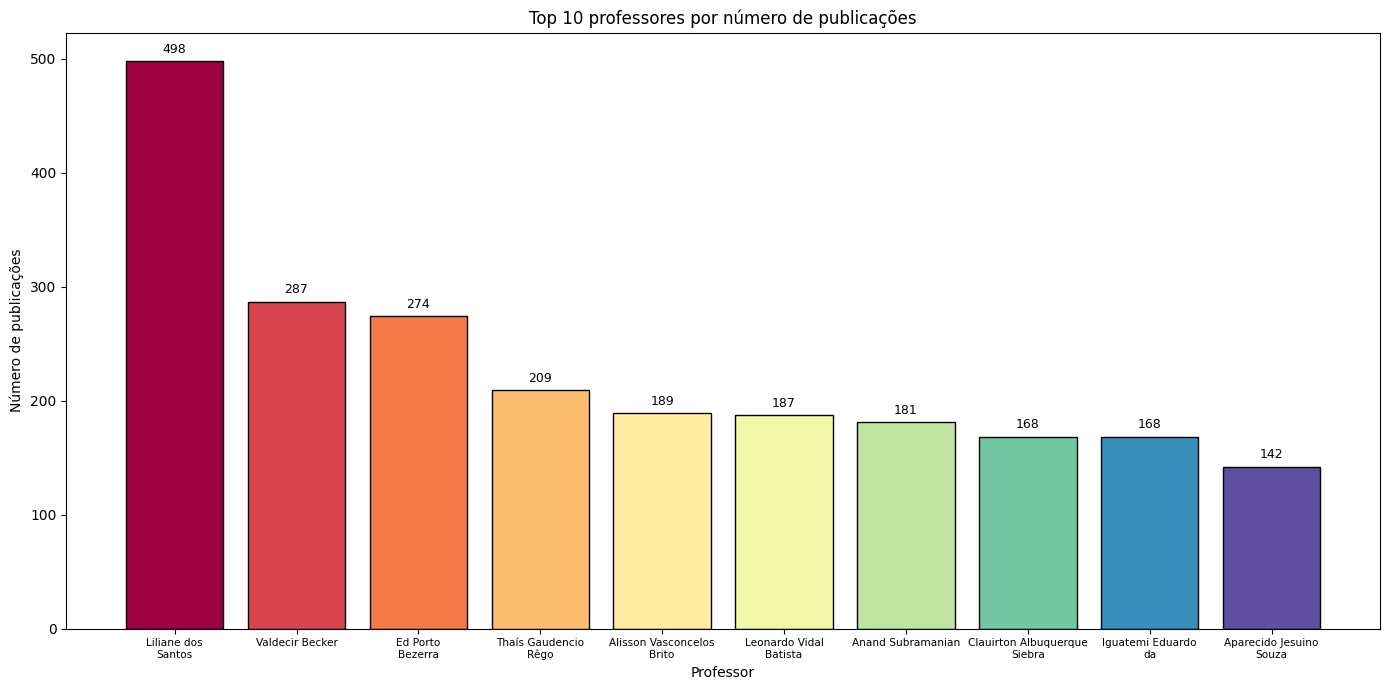

In [41]:
plt.figure(figsize=(14, 7))
# Usar top10 (já ordenado decrescentemente)
full_names = top_prod["nome"]
# Remover tokens 'de' e 'do' (case-insensitive)
tokens = full_names.apply(
    lambda s: [t for t in s.split() if t.lower() not in {"de", "do"}]
)
first_two = tokens.apply(lambda ts: " ".join(ts[:2]))
third = tokens.apply(lambda ts: ts[2] if len(ts) > 2 else "")
names = (first_two + "\n" + third).str.strip()  # duas linhas para melhorar leitura
counts = top_prod["quantidade_producoes_bibliograficas"].astype(int)
# Paleta coolwarm: mapear cada barra para uma cor
cmap = plt.get_cmap("Spectral")
colors = [
    cmap(i / (len(counts) - 1 if len(counts) > 1 else 1)) for i in range(len(counts))
]
# Plotar barras verticais
bars = plt.bar(names, counts, color=colors, edgecolor="black")
# Adicionar rótulos com o número de publicações acima de cada barra
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + max(counts) * 0.01,
        f"{int(height)}",
        ha="center",
        va="bottom",
        fontsize=9,
    )
plt.xlabel("Professor")
plt.ylabel("Número de publicações")
plt.title("Top 10 professores por número de publicações")
# Ajustes de layout para legibilidade dos rótulos do eixo x
plt.xticks(rotation=0, fontsize=7.6)
plt.gcf().subplots_adjust(bottom=0.25)
plt.tight_layout()
plt.show()


In [42]:
ranking_coaut = (
    df.groupby("nome")["quantidade_coautores"]
    .sum()
    .reset_index()
    .sort_values("quantidade_coautores", ascending=False)
)

In [43]:
top_coaut = ranking_coaut.head(10).reset_index(drop=True)

top_coaut

,nome,quantidade_coautores
0,Liliane dos Santos Machado,316
1,Alisson Vasconcelos de Brito,302
2,Thaís Gaudencio do Rêgo,256
3,Ed Porto Bezerra,233
4,Leonardo Vidal Batista,228
5,Anand Subramanian,223
6,Clauirton de Albuquerque Siebra,215
7,Tiago Pereira do Nascimento,201
8,Yuska Paola Costa Aguiar,196
9,Iguatemi Eduardo da Fonseca,182


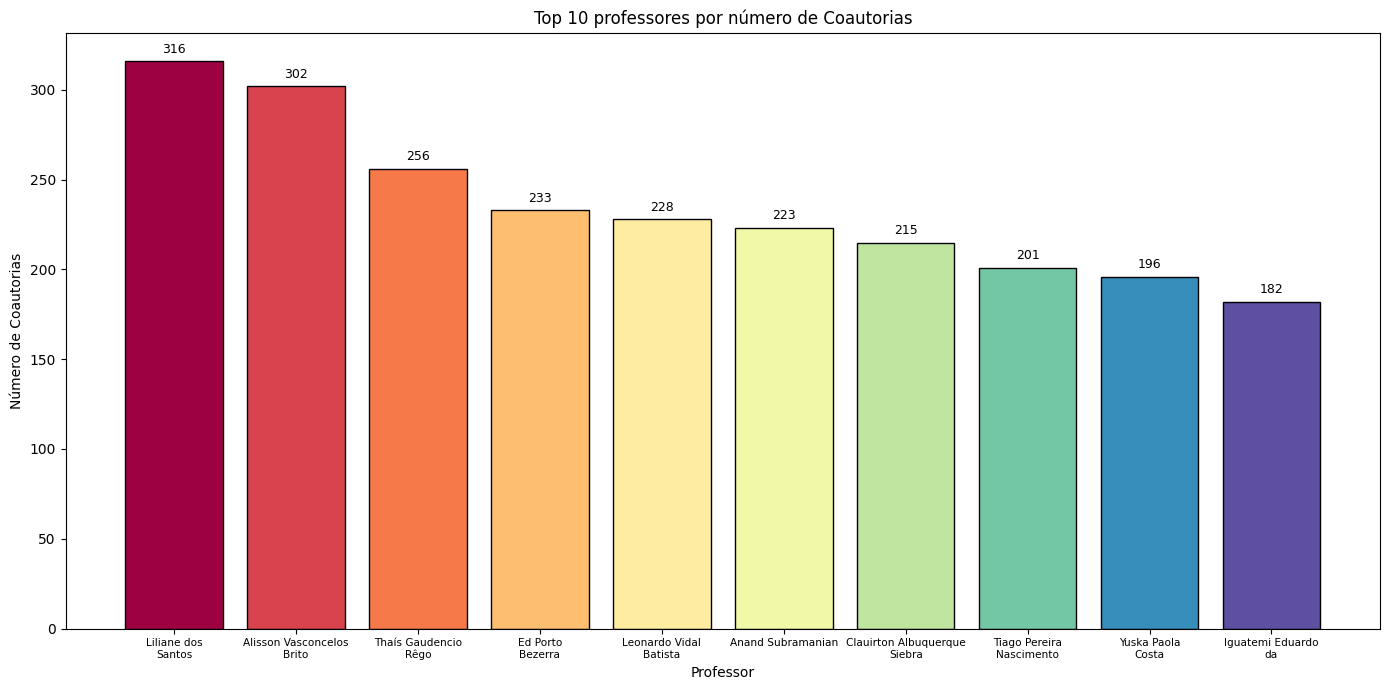

In [44]:
plt.figure(figsize=(14, 7))
# Usar top10 (já ordenado decrescentemente)
full_names = top_coaut["nome"]
# Remover tokens 'de' e 'do' (case-insensitive)
tokens = full_names.apply(
    lambda s: [t for t in s.split() if t.lower() not in {"de", "do"}]
)
first_two = tokens.apply(lambda ts: " ".join(ts[:2]))
third = tokens.apply(lambda ts: ts[2] if len(ts) > 2 else "")
names = (first_two + "\n" + third).str.strip()  # duas linhas para melhorar leitura
counts = top_coaut["quantidade_coautores"].astype(int)
# Paleta coolwarm: mapear cada barra para uma cor
cmap = plt.get_cmap(name="Spectral")
colors = [
    cmap(i / (len(counts) - 1 if len(counts) > 1 else 1)) for i in range(len(counts))
]
# Plotar barras verticais
bars = plt.bar(names, counts, color=colors, edgecolor="black")
# Adicionar rótulos com o número de publicações acima de cada barra
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + max(counts) * 0.01,
        f"{int(height)}",
        ha="center",
        va="bottom",
        fontsize=9,
    )
plt.xlabel("Professor")
plt.ylabel("Número de Coautorias")
plt.title("Top 10 professores por número de Coautorias")
# Ajustes de layout para legibilidade dos rótulos do eixo x
plt.xticks(rotation=0, fontsize=7.6)
plt.gcf().subplots_adjust(bottom=0.25)
plt.tight_layout()
plt.show()

In [45]:
top_coaut

,nome,quantidade_coautores
0,Liliane dos Santos Machado,316
1,Alisson Vasconcelos de Brito,302
2,Thaís Gaudencio do Rêgo,256
3,Ed Porto Bezerra,233
4,Leonardo Vidal Batista,228
5,Anand Subramanian,223
6,Clauirton de Albuquerque Siebra,215
7,Tiago Pereira do Nascimento,201
8,Yuska Paola Costa Aguiar,196
9,Iguatemi Eduardo da Fonseca,182


Professores com mais contribuições e coautores (resumo a partir de `ranking_prod` / `top10`)

Top 10 pesquisadores por número de publicações (coluna `quantidade_producoes_bibliograficas`):

1. Liliane dos Santos Machado — 498  
2. Valdecir Becker — 287  
3. Ed Porto Bezerra — 274  
4. Thaís Gaudencio do Rêgo — 209  
5. Alisson Vasconcelos de Brito — 189  
6. Leonardo Vidal Batista — 187  
7. Anand Subramanian — 181  
8. Clauirton de Albuquerque Siebra — 168  
9. Iguatemi Eduardo da Fonseca — 168  
10. Aparecido Jesuino de Souza — 142

Top 10 pesquisadores por número de coautoria total (coluna `quantidade_coautores`):

1. Liliane dos Santos Machado — 316  
2. Alisson Vasconcelos de Brito — 302
3. Thaís Gaudencio do Rêgo — 256
4. Ed Porto Bezerra — 233
5. Leonardo Vidal Batista — 228
6. Anand Subramanian — 223
7. Clauirton de Albuquerque Siebra — 215  
8. Tiago Pereira do Nascimento — 201  
9. Yuska Paola Costa Aguiar — 196
10. Tiago Maritan Ugulino de Araújo — 182

Observações rápidas
- Há forte concentração: em produção, o topo (498) supera bem o 10º (142); 
- Há sobreposição relevante entre os dois rankings (ex.: Liliane, Alisson, Thaís, Ed, Anand, Leonardo, Clauirton), 
    mas não perfeita: alguns nomes sobem/descem quando medimos conexões em vez de volume.
- Para medida mais fiel de colaboração, idealmente trabalhar com coautores distintos (deduplicados) e não apenas ocorrências.



### 2- Qual é a relação entre a quantidade de anos de experiência e a produção bibliográfica?

- Definição: verificação de como se comporta a disperção dos valores numéricos dos anos de experiência e a quantidade de produções.


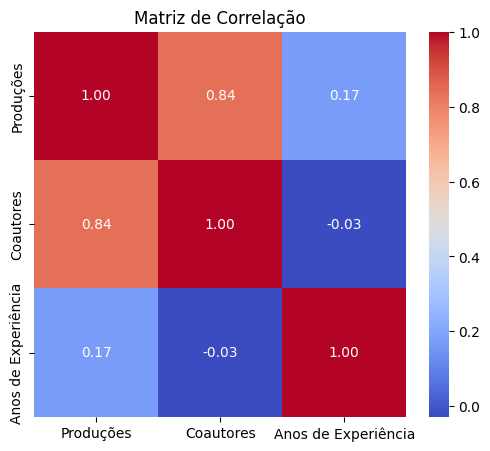

In [47]:
cols = [
    "quantidade_producoes_bibliograficas",
    "quantidade_coautores",
    "anos_experiencia",
]

colunas_legenda = {
    "quantidade_producoes_bibliograficas": "Produções",
    "quantidade_coautores": "Coautores",
    "anos_experiencia": "Anos de Experiência",
}

df_corr = df[cols].dropna().rename(columns=colunas_legenda)

# Calcula a matriz de correlação
corr_matrix = df_corr.corr()

plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlação")
plt.show()

### 3- Como o nível de formação influencia a produção bibliográfica (mestrado, doutorado e pós-doutorado)?

- Variáveis: dummies/níveis categóricos de formação máxima e indicadores de pós‑doutorado.
- Abordagem: modelos lineares (ANOVA/OLS) comparando médias condicionais de produção; controles por experiência e rede.
- Interpretação: diferenças médias associadas a cada nível; intervalos de confiança; tamanho de efeito.
- Visualização: boxplots/violin por nível de formação, com sobreposição de médias/IC.


### 4- Como é o grafo de produção com coautoria?

- Construção: grafo não direcionado com nós = pesquisadores e arestas ponderadas pelo número de publicações em coautoria.
- Métricas: grau, betweenness, eigenvector; comunidades (Louvain/Leiden).
- Visualização: layout forçado (Fruchterman‑Reingold/ForceAtlas2) com cor por comunidade e tamanho por centralidade.
- Saídas: top nós por centralidade e subgrafos das comunidades principais.


In [49]:
prof_names = set(df["nome"].dropna())
pairs = coautores_df[coautores_df["coautor"].isin(prof_names)]
pairs = pairs[pairs["nome"] != pairs["coautor"]]
pc = pairs.groupby(["nome", "coautor"]).size().reset_index(name="count")

In [50]:
edge_agg = defaultdict(int)
for _, r in pc.iterrows():
    a, b, c = r["nome"], r["coautor"], int(r["count"])
    edge_agg[tuple(sorted((a, b)))] += c

prod_counts = (
    df.set_index("nome")["quantidade_producoes_bibliograficas"].fillna(0).to_dict()
)
vals = np.array(list(prod_counts.values()) or [0], dtype=float)
mn, mx = vals.min(), vals.max()
min_size, max_size = 24, 140  # maiores para destaque


def scale_size(v):
    if mx == mn:
        return (min_size + max_size) / 2
    # escala linear
    return float(min_size + (v - mn) / (mx - mn) * (max_size - min_size))


weights = np.array(list(edge_agg.values()) or [1], dtype=float)
wmin, wmax = weights.min(), weights.max()
min_w, max_w = 1.0, 10.0


def scale_w(w):
    if wmax == wmin:
        return (min_w + max_w) / 2
    return float(min_w + (w - wmin) / (wmax - wmin) * (max_w - min_w))


G = nx.Graph()
for n in sorted(prof_names):
    G.add_node(n, producoes=int(prod_counts.get(n, 0)))
for (a, b), w in edge_agg.items():
    G.add_edge(a, b, weight=int(w))

pos = nx.spring_layout(G, seed=1)

edge_traces = []
for u, v, data in G.edges(data=True):
    x0, y0 = pos[u]
    x1, y1 = pos[v]
    w = data.get("weight", 1)
    edge_traces.append(
        go.Scatter(
            x=[x0, x1, None],
            y=[y0, y1, None],
            mode="lines",
            line=dict(width=scale_w(w), color="rgba(100,100,100,0.5)"),
            hoverinfo="text",
            text=f"{u} — {v}<br>Coautorias: {w}",
            showlegend=False,
        )
    )

node_x = [pos[n][0] for n in G.nodes()]
node_y = [pos[n][1] for n in G.nodes()]
node_sizes = [scale_size(G.nodes[n]["producoes"]) for n in G.nodes()]
node_text = [f"{n}<br>Produções: {G.nodes[n]['producoes']}" for n in G.nodes()]

node_trace = go.Scatter(
    x=node_x,
    y=node_y,
    mode="markers+text",
    text=list(G.nodes()),
    textposition="top center",
    hoverinfo="text",
    hovertext=node_text,
    marker=dict(
        size=node_sizes,
        color=[prod_counts.get(n, 0) for n in G.nodes()],
        colorscale="Greens",
        colorbar=dict(title="Produções"),
        line=dict(width=2, color="rgba(30,30,30,0.85)"),
        opacity=0.95,
        symbol="circle",
    ),
    textfont=dict(size=11),
)

fig = go.Figure(
    data=edge_traces + [node_trace],
    layout=go.Layout(
        title="Rede de coautoria — CI",
        showlegend=False,
        hovermode="closest",
        margin=dict(b=20, l=5, r=5, t=40),
        xaxis=dict(
            showgrid=False,
            zeroline=False,
            showticklabels=False,
            scaleanchor="y",
            scaleratio=1,
        ),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        dragmode="pan",
    ),
)

fig.update_layout(width=2000, height=1000)
fig.show(config={"scrollZoom": True})


In [ ]:
def normalizar_lab(nome):
    if not nome:
        return ""
    # Remove espaços e converte para maiúsculo
    nome = nome.strip().upper()
    # Trata variações comuns
    mapeamento = {
        "LAVID": "LAVID",
        "LAVI": "LAVID",
        "LAViD": "LAVID",
        "ARIA": "ARIA",
    }
    return mapeamento.get(nome, nome)


prof_lab_map = {}
with open("../data/prof_labs.csv", encoding="utf-8") as f:
    reader = csv.DictReader(f)
    for row in reader:
        prof = row["Nome dos Professores"].strip()
        labs = row["Laboratório"].split("/") if row["Laboratório"] else []
        # Se tiver múltiplos labs, usa o primeiro
        lab = labs[0].strip() if labs else ""
        prof_lab_map[prof] = normalizar_lab(lab)

# Dicionário de cores para cada laboratório


##Função pra abreviar o nome e não ficar muito poluido nas linhas de coautoria


def abreviar_nome(nome):
    partes = nome.split()
    return " ".join(partes[:2]) if len(partes) >= 2 else nome


# Filtra apenas professores do ARIA e LAVID
aria_lavid_profs = set()
with open("../data/prof_labs.csv", encoding="utf-8") as f:
    reader = csv.DictReader(f)
    for row in reader:
        prof = row["Nome dos Professores"].strip()
        labs = row["Laboratório"].split("/") if row["Laboratório"] else []
        labs = [normalizar_lab(lab.strip()) for lab in labs]
        if "ARIA" in labs or "LAVID" in labs:
            aria_lavid_profs.add(prof)

# Filtra as arestas para incluir apenas conexões entre professores do ARIA e LAVID
pairs_filtered = pairs[
    (pairs["nome"].isin(aria_lavid_profs)) & (pairs["coautor"].isin(aria_lavid_profs))
]

# Conta publicações entre cada par de professores
publicacoes_entre_profs = defaultdict(int)
for _, row in pairs_filtered.iterrows():
    par = tuple(sorted([row["nome"], row["coautor"]]))
    publicacoes_entre_profs[par] += 1

# Recria o edge_agg apenas com as conexões filtradas
edge_agg_filtered = defaultdict(int)
for (a, b), count in publicacoes_entre_profs.items():
    edge_agg_filtered[tuple(sorted((a, b)))] = count

# Cria o grafo filtrado
G_filtered = nx.Graph()
for n in sorted(aria_lavid_profs):
    G_filtered.add_node(n, producoes=int(prod_counts.get(n, 0)))
for (a, b), w in edge_agg_filtered.items():
    G_filtered.add_edge(a, b, weight=int(w), publicacoes=w)

pos_filtered = nx.spring_layout(G_filtered, seed=1)

# Cria as arestas
edge_traces = []
for u, v, data in G_filtered.edges(data=True):
    x0, y0 = pos_filtered[u]
    x1, y1 = pos_filtered[v]
    w = data.get("weight", 1)

    w_scaled = scale_w(w)

    # Linha
    edge_traces.append(
        go.Scatter(
            x=[x0, x1],
            y=[y0, y1],
            mode="lines",
            line=dict(width=w_scaled, color="rgba(100,100,100,0.5)"),
            hoverinfo="skip",
            showlegend=False,
        )
    )

    # Ponto invisível no meio
    xm = (x0 + x1) / 2
    ym = (y0 + y1) / 2

    u_short = abreviar_nome(u)
    v_short = abreviar_nome(v)

    edge_traces.append(
        go.Scatter(
            x=[xm],
            y=[ym],
            mode="markers",
            marker=dict(size=15, color="rgba(0,0,0,0)"),
            hoverinfo="text",
            hoverlabel=dict(bgcolor="white"),
            hovertemplate=f"{u_short} – {v_short}<br>Coautorias: {w}<extra></extra>",
            showlegend=False,
        )
    )


# Preparação dos dados dos nós
node_x = []
node_y = []
node_sizes = []
node_text = []
node_names = []
node_prods = []

for n in G_filtered.nodes():
    node_x.append(pos_filtered[n][0])
    node_y.append(pos_filtered[n][1])
    producoes = G_filtered.nodes[n]["producoes"]
    node_sizes.append(scale_size(producoes))
    lab = prof_lab_map.get(n, "")
    node_text.append(
        f"Professor: {n}<br>Laboratório: {lab}<br>Total de produções: {producoes}"
    )
    node_names.append(n)
    node_prods.append(producoes)

# Cria o trace dos nós
node_trace = go.Scatter(
    x=node_x,
    y=node_y,
    mode="markers+text",
    text=node_names,
    textposition="top center",
    hoverinfo="text",
    hovertext=node_text,
    hoverlabel=dict(bgcolor="white"),  # Fundo branco para melhor legibilidade
    marker=dict(
        size=node_sizes,
        color=node_prods,  # Usa o número de produções para a cor
        colorscale="Greens",  # Verde do mais claro ao mais escuro
        colorbar=dict(title="Produções"),
        line=dict(width=2, color="rgba(30,30,30,0.85)"),
        opacity=0.95,
        symbol="circle",
    ),
    textfont=dict(size=11),
)

# Cria a figura
fig = go.Figure(
    data=edge_traces + [node_trace],
    layout=go.Layout(
        title="Rede de coautoria - ARIA/LAVID<br><sub>Nós coloridos por número de produções, espessura das arestas por número de publicações em conjunto</sub>",
        showlegend=False,
        hovermode="closest",
        margin=dict(b=20, l=5, r=5, t=70),
        xaxis=dict(
            showgrid=False,
            zeroline=False,
            showticklabels=False,
            scaleanchor="y",
            scaleratio=1,
        ),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        dragmode="pan",
    ),
)

fig.update_layout(width=2000, height=1000)
fig.show(config={"scrollZoom": True})

### 5- Quais clusters emergem a partir dos títulos dos artigos?.

- Representação: TF‑IDF de títulos (ou embeddings) agregados por pesquisador ou por publicação.
- Algoritmos: K‑Means (baseline) e/ou HDBSCAN; redução UMAP para 2D.
- Validação: Silhouette/Davies‑Bouldin; inspeção de termos dominantes por cluster.
- Visualização: nuvem de palavras por cluster e scatter 2D (UMAP) colorido por cluster.


## Conclusão

Síntese esperada:

- Ranking de pesquisadores por produção e coautoria e a estrutura de colaboração observada.
- Relações entre experiência, nível de formação e produtividade.
- Perfis temáticos identificados a partir dos títulos dos artigos.

Limitações:

- Lacunas e desatualizações nos currículos; ambiguidade de nomes/identificadores.
- Diferenças de cobertura entre áreas e anos; variações na classificação de tipos de produção.

Trabalhos futuros e melhorias:

- Desambiguação com ORCID/DOI e enriquecimento via bases externas.
- Modelos de NLP mais robustos (embeddings contextuais) e análise temporal fina de tópicos.
- Dashboards interativos para acompanhamento contínuo.

> Observação: Este notebook se baseia nos scripts do repositório (`scripts/download_profile.py` e `scripts/parse_profiles.py`). Para reproduzir a coleta e parsing, siga as instruções do `README.md` (uso de `uv`).
